# Figure 1
all data assumed to be in ../../data

# setup and load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
from scipy.stats import ks_2samp, pearsonr, linregress
import os

from rna_secstruct import SecStruct

from dms_3d_features.plotting import *

## added functions

In [2]:
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())


def r2(x, y):
    return pearsonr(x, y)[0] ** 2

In [3]:
def generate_small_plot(x_label, y_label):
    fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=600)
    ax.set_xlabel(x_label, labelpad=2)
    ax.set_ylabel(y_label, labelpad=2)
    return fig, ax

In [4]:
DATA_PATH = "../../data"

## check paths

In [5]:
if not os.path.exists(DATA_PATH):
    raise ValueError(f"Data path {DATA_PATH} does not exist")
os.makedirs("pngs", exist_ok=True)

## load data

In [6]:
df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_construct_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2.json")
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
# restore original no helix behavior
df = df.query("r_type != 'WC'").copy()
df_motif = df_motif.query("m_token.str.startswith('HELIX') == False").copy()

with np.errstate(divide="ignore"):
    df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
print(len(df))
df = df.query("r_data_outlier == False").copy()
print(len(df))

237528
235104


/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_24574/2751425031.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)


In [7]:
df["m_token"].value_counts()

m_token
2x2    184748
1x1      8862
3x2      5970
2x1      5552
3x3      4936
4x4      4214
5x4      3499
3x1      3252
6x3      2419
3x0      1770
4x3      1651
1x0      1455
5x3      1341
4x1      1337
2x0      1321
4x2       923
5x1       722
5x0       614
5x2       518
Name: count, dtype: int64

In [8]:
df_motif["m_token"].value_counts()

m_token
2x2    41010
1x1     2630
2x1     1510
3x2     1244
3x3      985
3x1      762
4x4      622
1x0      521
5x4      518
3x0      489
2x0      374
6x3      364
4x1      312
4x3      312
4x2      208
5x3      208
5x0      104
5x2      104
5x1      104
Name: count, dtype: int64

# Plots

## Figure 1B: construct to highlight diversity of structures. Find one with the most different motifs

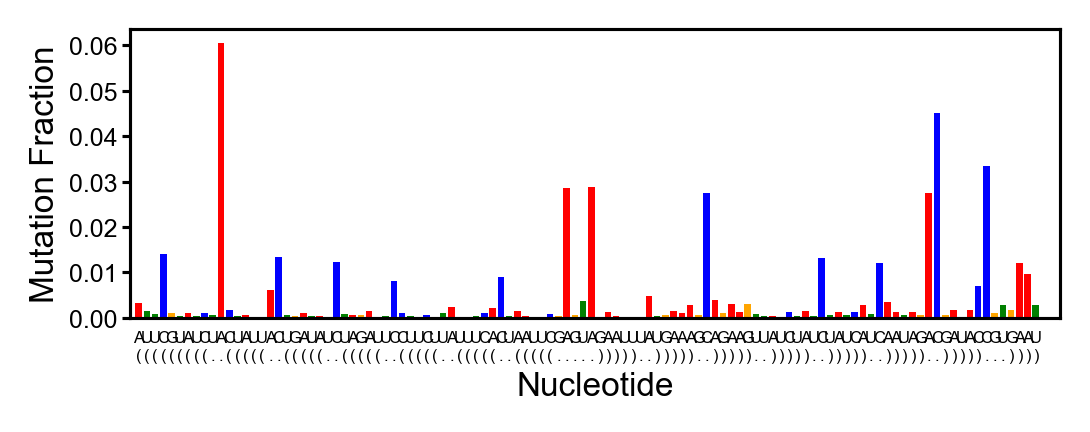

In [9]:
def figure_1b(df_construct, ax):
    row = df_construct.iloc[7000].to_dict()
    row["sequence"] = row["sequence"][1:]
    row["structure"] = row["structure"][1:]
    row["data"] = row["data"][1:]
    ax = plot_pop_avg_from_row(row, ax=ax)
    ax.set_xlabel("Nucleotide", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
    ax.set_xlim(-1, 112)
    ax.tick_params(axis="x", which="both", bottom=False, top=False, size=-1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=4)


fig, ax = plt.subplots(figsize=(4.00, 1.25), dpi=300)
figure_1b(df_construct, ax)

## Figure 1C: mutation fraction reproducibility

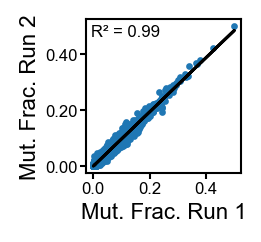

In [ ]:
def figure_1c(df_construct, df_construct_2, ax):
    # prepare data for plot
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name")
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    # generate plot
    scatter_plot_w_regression(df_data, ax, "data_1", "data_2", size=2, pos="top left")
    ax.set_xlabel("Mut. Frac. Run 1", labelpad=2)
    ax.set_ylabel("Mut. Frac. Run 2", labelpad=2)
    ax.set_xticks([0.00, 0.20, 0.40])
    ax.set_yticks([0.00, 0.20, 0.40], labels=["0.00", "0.20", "0.40"])
    publication_style_ax(ax)


fig, ax = plt.subplots(figsize=(1.0, 1.0), dpi=200)
figure_1c(df_construct, df_construct_2, ax)

## Figure 1D: histogram of DMS reactivity in Ln space

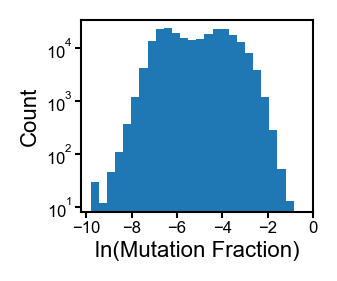

In [11]:
def figure_1d(df, ax):
    ax.hist(df["ln_r_data"], bins=25)
    ax.set_yscale("log")
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_yticks([10, 100, 1000, 10000])
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    publication_style_ax(ax)


fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1d(df, ax)

## Figure 1E: how often does each motif occur

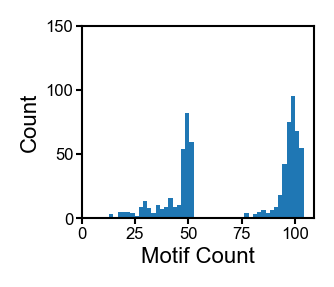

In [12]:
def figure_1e(df_motif, ax):
    data = []
    for i, group in df_motif.groupby("m_sequence"):
        data.append([i, len(group)])
    df_counts = pd.DataFrame(data, columns=["m_sequence", "count"])
    plt.hist(df_counts["count"], bins=50)
    ax.set_xlabel("Motif Count", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_yticks([0, 50, 100, 150])
    publication_style_ax(ax)


fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1e(df_motif, ax)

In [13]:
# Get min and max counts
data = []
for i, group in df_motif.groupby("m_sequence"):
    data.append([i, len(group)])
df_counts = pd.DataFrame(data, columns=["m_sequence", "count"])
print(f"Min motif count: {df_counts['count'].min()}")
print(f"Max motif count: {df_counts['count'].max()}")

Min motif count: 5
Max motif count: 104


## Figure 1F: example motif

In [14]:
print(df["m_sequence"].unique())

['AAA&UAU' 'AAA&UCU' 'AAA&UGU' 'AAAA&UAAU' 'AAAA&UACU' 'AAAA&UAGU'
 'AAAA&UCAU' 'AAAA&UCGU' 'AAAA&UGAU' 'AAAA&UGGU' 'AAAC&GAAU' 'AAAC&GACU'
 'AAAC&GAGU' 'AAAC&GCAU' 'AAAC&GCGU' 'AAAC&GCU' 'AAAC&GGAU' 'AAAC&GGGU'
 'AAACG&CUAU' 'AAAG&CAAU' 'AAAG&CACU' 'AAAG&CAGU' 'AAAG&CCAU' 'AAAG&CCGU'
 'AAAG&CGAU' 'AAAG&CGGU' 'AAAGG&UACU' 'AAAU&AAAU' 'AAAU&AACU' 'AAAU&AAGU'
 'AAAU&ACAU' 'AAAU&ACGU' 'AAAU&AGAU' 'AAAU&AGGU' 'AAC&GAU' 'AAC&GCU'
 'AACA&UAAU' 'AACA&UACU' 'AACA&UCAU' 'AACA&UCCU' 'AACA&UUAU' 'AACA&UUCU'
 'AACC&GAAU' 'AACC&GACU' 'AACC&GCAU' 'AACC&GCCU' 'AACC&GUAU' 'AACC&GUCU'
 'AACG&CAAU' 'AACG&CACU' 'AACG&CCAU' 'AACG&CCCU' 'AACG&CUAU' 'AACG&CUCU'
 'AACG&CUGU' 'AACU&AACU' 'AACU&ACAU' 'AACU&ACCU' 'AACU&AUAU' 'AACU&AUCU'
 'AACU&AUGU' 'AAG&CAU' 'AAG&CCU' 'AAG&CGU' 'AAG&CU' 'AAGA&UAAU'
 'AAGA&UGAU' 'AAGC&GAAU' 'AAGC&GGAU' 'AAGCAG&UCAGGU' 'AAGG&CAAU'
 'AAGG&CGAU' 'AAGGAA&UGU' 'AAGU&AGAU' 'AAU&AAU' 'AAU&ACU' 'AAU&AGU'
 'AAU&GAU' 'AAUA&UCAU' 'AAUA&UCCU' 'AAUA&UUAU' 'AAUA&UUCU' 'AAUA&UUGU'
 'AAUC&GCAU

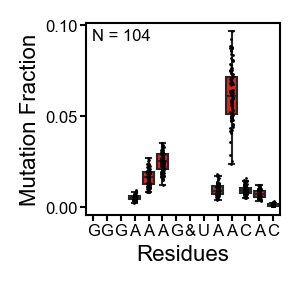

In [40]:
def figure_1f(df, ax):
    df_motif_example = df[df["m_sequence"] == "GGGAAAG&UAACAC"]
    plot_motif_boxplot_stripplot(df_motif_example, ax=ax)
    ax.set_xlabel("Residues", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    # Add N = number of data instances in the top left corner
    n_instances = len(df_motif_example.query("r_loc_pos == 4"))
    ax.text(
        0.03,
        0.97,
        f"N = {n_instances}",
        transform=ax.transAxes,
        verticalalignment="top",
        fontname="Arial",
        fontsize=6,
    )
    publication_style_ax(ax)


fig, ax = plt.subplots(figsize=(1.25, 1.25), dpi=200)
figure_1f(df, ax)

## Figure 1G: coefficient of variation

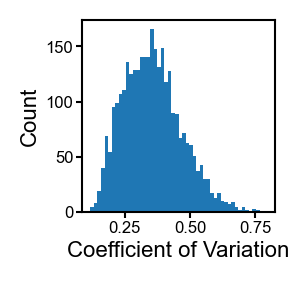

In [ ]:
def figure_1g(df, ax):
    data = []
    for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
        data.append(group["r_data"].std() / group["r_data"].mean())
    plt.hist(data, bins=50)
    ax.set_xlabel("Coefficient of Variation", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_yticks([0, 50, 100, 150])
    publication_style_ax(ax)


fig, ax = plt.subplots(figsize=(1.25, 1.25), dpi=200)
figure_1g(df, ax)

In [17]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    data.append(group["r_data"].std() / group["r_data"].mean())
np.mean(data)

0.35615136131426856

## Figure 1H: coefficient of variation with different groupings

In [21]:
# Group the data and calculate statistics
df_second_stack = (
    df.groupby(
        ["m_sequence", "r_loc_pos", "m_second_flank_bp_5p", "m_second_flank_bp_3p"]
    )
    .agg(
        m_token=("m_token", "first"),
        likely_pair=("likely_pair", "first"),
        m_flank_bp_5p=("m_flank_bp_5p", "first"),
        m_flank_bp_3p=("m_flank_bp_3p", "first"),
        p5_res=("p5_res", "first"),
        p3_res=("p3_res", "first"),
        r_stack=("r_stack", "first"),
        mean_ln_r_data=("ln_r_data", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        count=("ln_r_data", "count"),
        r_type=("r_type", "first"),
    )
    .reset_index()
)

In [22]:
if not os.path.exists(f"{DATA_PATH}/csvs/randomized_cvs.csv"):
    data = []
    for i, row in df_second_stack.query("count >= 5").iterrows():
        df_sub = df.query(
            f"m_sequence == '{row['m_sequence']}' and r_loc_pos == {row['r_loc_pos']}"
        ).sample(row["count"])
        cv = np.std(df_sub["r_data"]) / np.mean(df_sub["r_data"])
        data.append(
            {
                "m_sequence": row["m_sequence"],
                "r_loc_pos": row["r_loc_pos"],
                "cv_r_data": cv,
                "r_type": row["r_type"],
            }
        )
    df_sub = pd.DataFrame(data)
    df_sub.to_csv(f"{DATA_PATH}/csvs/randomized_cvs.csv", index=False)
else:
    df_sub = pd.read_csv(f"{DATA_PATH}/csvs/randomized_cvs.csv")

In [23]:
df_cv = (
    df.groupby(["m_sequence", "r_loc_pos"])
    .agg(
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        r_type=("r_type", "first"),
    )
    .reset_index()
)
df_cv["data_type"] = "all"
df_second_stack_cv = df_second_stack.query("count >= 5").copy()
df_second_stack_cv["data_type"] = "Second Stack"
df_all = pd.concat([df_second_stack_cv, df_cv]).reset_index(drop=True)

In [24]:
print(
    "average no group WC: "
    + str(df_cv.query("r_type == 'Flank-WC'")["cv_r_data"].mean())
)
print(
    "average with second WC grouping : "
    + str(df_second_stack_cv.query("r_type == 'Flank-WC'")["cv_r_data"].mean())
)
print(
    "average with random grouping: "
    + str(df_sub.query("r_type == 'Flank-WC'")["cv_r_data"].mean())
)
print(
    "average no group NON-WC: "
    + str(df_cv.query("r_type == 'NON-WC'")["cv_r_data"].mean())
)
print(
    "average with second WC grouping : "
    + str(df_second_stack_cv.query("r_type == 'NON-WC'")["cv_r_data"].mean())
)
print(
    "average with random grouping: "
    + str(df_sub.query("r_type == 'NON-WC'")["cv_r_data"].mean())
)

average no group WC: 0.4248140744670936
average with second WC grouping : 0.33967051908293167
average with random grouping: 0.3736676225315957
average no group NON-WC: 0.29662828917958667
average with second WC grouping : 0.22321748277691733
average with random grouping: 0.26975520574242867


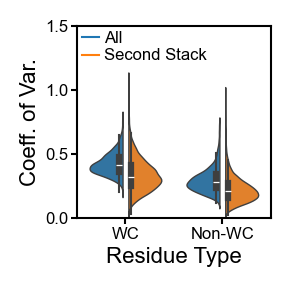

In [29]:
def figure_1h(df_all, ax):
    sns.violinplot(
        data=df_all,
        y="cv_r_data",
        x="r_type",
        density_norm="width",
        linewidth=0.5,
        hue="data_type",
        split=True,
        gap=0.15,
        ax=ax,
        hue_order=["all", "Second Stack"],
    )
    ax.set_xlabel("Residue Type", labelpad=2)
    ax.set_ylabel("Coeff. of Var.", labelpad=2)
    ax.legend_ = None
    ax.set_ylim(0, 1.5)
    ax.set_xticks([0, 1], labels=["WC", "Non-WC"])
    publication_style_ax(ax)
    add_legend(ax, ["All", "Second Stack"], loc="upper left")


fig, ax = plt.subplots(figsize=(1.25, 1.25), dpi=200)
figure_1h(df_all, ax)

## Figure 1B-H: all together

/Users/jyesselman2/Library/CloudStorage/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:826: UserWarning: Subplots won't fit vertically! Required height: 4.24", Figure height: 4.15". Consider increasing figure height or reducing subplot height/spacing.
  warnings.warn(


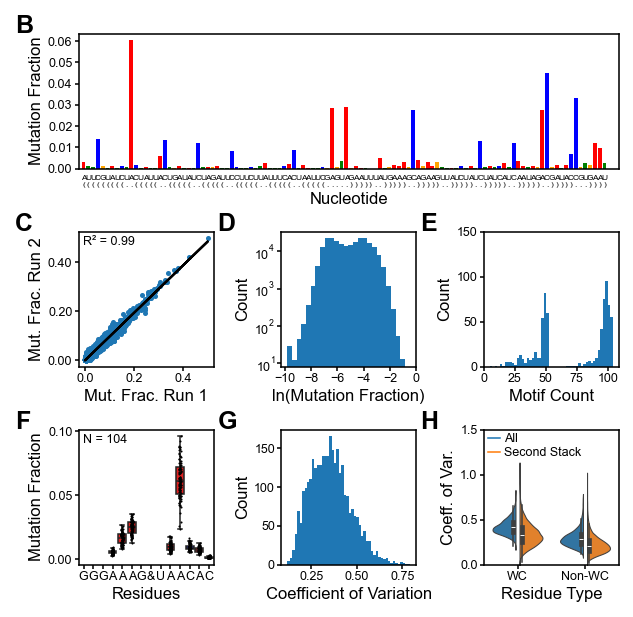

In [41]:
fig_size = (4.25, 4.15)
layout = (3, 3)
subplot_size = (0.90, 0.90)
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.42,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.70},
}
coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
coords_list = merge_neighboring_coords(coords_list, [0, 1, 2])
fig = plt.figure(figsize=fig_size, dpi=150)

ax1 = fig.add_axes(coords_list[0])
figure_1b(df_construct, ax1)

ax2 = fig.add_axes(coords_list[1])
figure_1c(df_construct, df_construct_2, ax2)
ax3 = fig.add_axes(coords_list[2])
figure_1d(df, ax3)
ax4 = fig.add_axes(coords_list[3])
figure_1e(df_motif, ax4)
ax5 = fig.add_axes(coords_list[4])
figure_1f(df, ax5)
ax6 = fig.add_axes(coords_list[5])
figure_1g(df, ax6)
ax7 = fig.add_axes(coords_list[6])
figure_1h(df_all, ax7)
add_subplot_labels(fig, coords_list, start="B", left_offset=0.10, top_offset=0.03)

fig.savefig("pngs/figure_1.png", dpi=600, bbox_inches="tight")